# General Imports

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from collections import namedtuple
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns

In [3]:
from icecream import ic

In [4]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms as transform_lib
from pytorch_lightning.callbacks import TQDMProgressBar
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [5]:
from dataset.cityscapes import Cityscapes
from dataset.cityscapes import CityscapesDataModule
from dataset.woodscape import WoodScapeDataset
from dataset.woodscape import WoodScapeDataModule
from dataset import WoodScapeSoilingDataset
from dataset import WoodScapeSoilingDataModule

In [6]:
from utils.display_images import denormalize_img
from utils import show_dataset_image, show_dataset_mask
from utils import show_prediction_images, show_prediction_uncertainty_images

In [7]:
from deeplab_v3p import DeepLabV3PlusModule
from dropblock import DropBlock2D

In [8]:
from ls_ood_detect.uncertainty_estimation import Hook
from ls_ood_detect.uncertainty_estimation import deeplabv3p_get_ls_mcd_samples
from ls_ood_detect.uncertainty_estimation import get_latent_represent_mcd_samples
from ls_ood_detect.uncertainty_estimation import get_dl_h_z
from ls_ood_detect.ood_detection_dataset import build_ood_detection_ds
from ls_ood_detect.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect.detectors import KDEClassifier, DetectorKDE
from ls_ood_detect.score import get_hz_scores
from ls_ood_detect.metrics import get_hz_detector_results
from ls_ood_detect.metrics import get_ood_detector_results
from ls_ood_detect.metrics import plot_roc_ood_detector
from ls_ood_detect.metrics import plot_auprc_ood_detector
from ls_ood_detect.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect.dimensionality_reduction import apply_pca_ds_split
from ls_ood_detect.dimensionality_reduction import apply_pca_transform

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Paths

Datasets paths:

In [10]:
cs_dataset_path = "./Data/DATASETS/CityScapes"
ws_data_path = "./Data/DATASETS/WoodScape/"
ws_soil_data_path = "./Data/DATASETS/WoodScape/soiling_dataset/"

Experiments path:

In [11]:
exp_path = "./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/"

Resnet Classification Model Number & checkpoint:

In [12]:
exp_model_name = "deeplabv3p-cityscapes/"

In [ ]:
cs_dlv3p_path = exp_path + exp_model_name + "models/version_158692/checkpoints/epoch=403-step=18584.ckpt"
cs_dlv3p_path

**Baseline models path:**

In [14]:
baseline_methods_path = "OoD_detection_baselines/"

Detection Baselines Samples Paths:

In [15]:
baselines_samples_path = "OoD_detection_baselines/"

In [ ]:
predicted_uncertainty_path = exp_path + exp_model_name + baseline_methods_path + "predicted_uncertainty/"
predicted_uncertainty_path

In [ ]:
msp_score_path = exp_path + exp_model_name + baseline_methods_path + "msp_score/"
msp_score_path

In [ ]:
energy_score_path = exp_path + exp_model_name + baseline_methods_path + "energy_score/"
energy_score_path

In [ ]:
m_dist_score_path = exp_path + exp_model_name + baseline_methods_path + "mahalanobis_dist_score/"
m_dist_score_path

In [ ]:
m_dist_penultimate_layer_score_path = exp_path + exp_model_name + baseline_methods_path + "mahalanobis_dist_penultimate_layer_score/"
m_dist_penultimate_layer_score_path

In [ ]:
knn_dist_score_path = exp_path + exp_model_name + baseline_methods_path + "knn_dist_score/"
knn_dist_score_path

In [ ]:
knn_dist_penultimate_layer_score_path = exp_path + exp_model_name + baseline_methods_path + "knn_dist_penultimate_layer_score/"
knn_dist_penultimate_layer_score_path

# Datasets

## Cityscapes

### Datamodules

In [21]:
batch_size = 1

__Cityscapes img_size (256, 512)__

In [22]:
cs_dm_normal_dlv3p = CityscapesDataModule(data_dir=cs_dataset_path,
                                          batch_size=batch_size,
                                          target_type='semantic',
                                          img_size=(256, 512),
                                          num_workers=10,
                                          drop_last=True,
                                          default_transforms=False, # Here this should be True!
                                          default_img_mask_transforms=True) # And here this should be False!

__Cityscapes img_size (483, 640)__

In [ ]:

cs_483640_dm_dlv3p = CityscapesDataModule(data_dir=cs_dataset_path,
                                          batch_size=batch_size,
                                          target_type='semantic',
                                          img_size=(483, 640),
                                          num_workers=10,
                                          drop_last=True,
                                          default_transforms=True, # Here this should be True!
                                          default_img_mask_transforms=False) # And here this should be False!        

__Cityscapes-Anomalies img_size (256, 512)__

In [23]:
cs_dm_anomal_dlv3p = CityscapesDataModule(data_dir=cs_dataset_path,
                                          batch_size=batch_size,
                                          target_type='semantic',
                                          img_size=(256, 512),
                                          num_workers=10,
                                          drop_last=True,
                                          default_transforms=False, # Here this should be False!
                                          default_img_mask_transforms=True) # And here this should be True! (Enable Anomalies)

### Cityscapes Dataloaders

In [24]:
cs_dlv3p_train_loader = cs_dm_normal_dlv3p.train_dataloader()
cs_dlv3p_valid_loader = cs_dm_normal_dlv3p.val_dataloader()
cs_dlv3p_test_loader = cs_dm_normal_dlv3p.test_dataloader()

In [25]:
cs_dlv3p_anomaly_valid_loader = cs_dm_anomal_dlv3p.anomaly_val_dataloader()
cs_dlv3p_anomaly_test_loader = cs_dm_anomal_dlv3p.anomaly_test_dataloader()

In [ ]:
cs_483640_dlv3p_valid_loader = cs_483640_dm_dlv3p.val_dataloader()
cs_483640_dlv3p_test_loader = cs_483640_dm_dlv3p.test_dataloader()

In [26]:
ic(len(cs_dlv3p_train_loader));
ic(len(cs_dlv3p_valid_loader));
ic(len(cs_dlv3p_test_loader));
ic(len(cs_dlv3p_anomaly_valid_loader));
ic(len(cs_dlv3p_anomaly_test_loader));
# ic(len(cs_483640_dlv3p_valid_loader));
# ic(len(cs_483640_dlv3p_test_loader));

ic| len(cs_dlv3p_train_loader): 2975
ic| len(cs_dlv3p_valid_loader): 500
ic| len(cs_dlv3p_test_loader): 1525
ic| len(cs_dlv3p_anomaly_valid_loader): 500
ic| len(cs_dlv3p_anomaly_test_loader): 1525


## Woodscape

### Datamodules

In [27]:
batch_size = 1

cmap = {0: [0, 0, 0],  # "void"
        1: [128, 64, 128],  # "road",
        2: [69, 76, 11],  # "lanemarks",
        3: [0, 255, 0],  # "curb",
        4: [220, 20, 60],  # "person",
        5: [255, 0, 0],  # "rider",
        6: [0, 0, 142],  # "vehicles",
        7: [119, 11, 32],  # "bicycle",
        8: [0, 0, 230],  # "motorcycle",
        9: [220, 220, 0]  # "traffic_sign",
        }

# same values as in VainF Repository! - Probably not the best Values for Woodscapes!
ws_dlv3p_norm_mean = [0.485, 0.456, 0.406]
ws_dlv3p_norm_std = [0.229, 0.224, 0.225]

__Woodscape img_size (483, 640)__

In [ ]:
ws_dm_normal_dlv3p = WoodScapeDataModule(dataset_dir=ws_data_path,
                                         img_size=(483, 640),
                                         batch_size=batch_size,
                                         default_transforms=True,
                                         label_colours=cmap,
                                         norm_mean=ws_dlv3p_norm_mean,
                                         norm_std=ws_dlv3p_norm_std,
                                         seed=9290,
                                         drop_last=True)
ws_dm_normal_dlv3p.setup()

DATASET Shuffle Random SEED:  9290


__Woodscape img_size (256, 512)__

In [28]:
ws_dm_normal_dlv3p_256_512 = WoodScapeDataModule(dataset_dir=ws_data_path,
                                         img_size=(256, 512),
                                         batch_size=batch_size,
                                         default_transforms=True,
                                         label_colours=cmap,
                                         norm_mean=ws_dlv3p_norm_mean,
                                         norm_std=ws_dlv3p_norm_std,
                                         seed=9290,
                                         drop_last=True)
ws_dm_normal_dlv3p_256_512.setup()

DATASET Shuffle Random SEED:  9290


__Woodscape-Anomalies img_size (483, 640)__

In [ ]:
ws_dm_anomal_dlv3p = WoodScapeDataModule(dataset_dir=ws_data_path,
                                         img_size=(483, 640),
                                         batch_size=batch_size,
                                         default_transforms=True,
                                         label_colours=cmap,
                                         norm_mean=ws_dlv3p_norm_mean,
                                         norm_std=ws_dlv3p_norm_std,
                                         seed=9290,
                                         drop_last=True)
ws_dm_anomal_dlv3p.setup()

DATASET Shuffle Random SEED:  9290


### Woodscape dataloaders

In [ ]:
ws_dlv3p_train_loader = ws_dm_normal_dlv3p.train_dataloader()
ws_dlv3p_valid_loader = ws_dm_normal_dlv3p.val_dataloader()
ws_dlv3p_test_loader = ws_dm_normal_dlv3p.test_dataloader()

In [ ]:
ws_dlv3p_anomaly_valid_loader = ws_dm_anomal_dlv3p.anomaly_val_dataloader()
ws_dlv3p_anomaly_test_loader = ws_dm_anomal_dlv3p.anomaly_test_dataloader()

In [30]:
ws_256512_dlv3p_valid_loader = ws_dm_normal_dlv3p_256_512.val_dataloader()
ws_256512_dlv3p_test_loader = ws_dm_normal_dlv3p_256_512.test_dataloader()

In [31]:
ic(len(ws_256512_dlv3p_valid_loader));
ic(len(ws_256512_dlv3p_test_loader));

ic| len(ws_256512_dlv3p_valid_loader): 1482
ic| len(ws_256512_dlv3p_test_loader): 823


## Woodscape-Soiling

### Datamodules

__Woodscape Soling OoD DeeplabV3+ (483, 640)__

In [34]:
woodscape_soil_483640_dm = WoodScapeSoilingDataModule(dataset_dir=ws_soil_data_path,
                                                      img_size=(483, 640),
                                                      batch_size=1,
                                                      default_transforms=True,
                                                      seed=9290)
woodscape_soil_483640_dm.setup()

ic| len(self.rgb_soil_images_list): 4000
ic| len(self.soil_annotations_gt_list): 4000
ic| len(self.soil_annotations_rgb_list): 4000
ic| dataset_train_len: 4000
ic| len(self.rgb_soil_images_list): 1000
ic| len(self.soil_annotations_gt_list): 1000
ic| len(self.soil_annotations_rgb_list): 1000
ic| dataset_test_len: 1000


DATASET Shuffle Random SEED:  9290


__Woodscape Soling OoD DeeplabV3+ (256, 512)__

In [32]:
woodscape_soil_256512_dm = WoodScapeSoilingDataModule(dataset_dir=ws_soil_data_path,
                                                      img_size=(256, 512),
                                                      batch_size=1,
                                                      default_transforms=True,
                                                      seed=9290)
woodscape_soil_256512_dm.setup()

ic| len(self.rgb_soil_images_list): 4000
ic| len(self.soil_annotations_gt_list): 4000
ic| len(self.soil_annotations_rgb_list): 4000
ic| dataset_train_len: 4000
ic| len(self.rgb_soil_images_list): 1000
ic| len(self.soil_annotations_gt_list): 1000
ic| len(self.soil_annotations_rgb_list): 1000
ic| dataset_test_len: 1000


DATASET Shuffle Random SEED:  9290


### Dataloaders

In [ ]:
ws_soiling_483640_valid_loader = woodscape_soil_483640_dm.val_dataloader()
ws_soiling_483640_test_loader = woodscape_soil_483640_dm.test_dataloader()

In [33]:
ws_soiling_256512_valid_loader = woodscape_soil_256512_dm.val_dataloader()
ws_soiling_256512_test_loader = woodscape_soil_256512_dm.test_dataloader()

In [34]:
# ic(len(ws_soiling_483640_valid_loader));
# ic(len(ws_soiling_483640_test_loader));
ic(len(ws_soiling_256512_valid_loader));
ic(len(ws_soiling_256512_test_loader));

ic| len(ws_soiling_256512_valid_loader): 800
ic| len(ws_soiling_256512_test_loader): 1000


# Deeplabv3+ Cityscapes Trained Model

In [188]:
cs_dlv3p_model = DeepLabV3PlusModule.load_from_checkpoint(checkpoint_path=cs_dlv3p_path)

In [189]:
cs_dlv3p_model;

In [190]:
ic(cs_dlv3p_model.pred_loss_type);
ic(cs_dlv3p_model.n_class);

ic| cs_dlv3p_model.pred_loss_type: 'focal_loss'
ic| cs_dlv3p_model.n_class: 20


In [191]:
cs_dlv3p_model.eval();

# Dataset Distribution Shift Detection Baselines

In [41]:
ic(len(cs_dlv3p_train_loader));
ic(len(cs_dlv3p_valid_loader));
ic(len(cs_dlv3p_test_loader));
ic("========================================");
ic(len(cs_dlv3p_anomaly_valid_loader));
ic(len(cs_dlv3p_anomaly_test_loader));
ic("========================================");
ic(len(ws_256512_dlv3p_valid_loader));
ic(len(ws_256512_dlv3p_test_loader));
ic("========================================");
ic(len(ws_soiling_256512_valid_loader));
ic(len(ws_soiling_256512_test_loader));

ic| len(cs_dlv3p_train_loader): 2975
ic| len(cs_dlv3p_valid_loader): 500


ic| len(cs_dlv3p_test_loader): 1525
ic| '========================================'
ic| len(cs_dlv3p_anomaly_valid_loader): 500
ic| len(cs_dlv3p_anomaly_test_loader): 1525
ic| '========================================'
ic| len(ws_256512_dlv3p_valid_loader): 1482
ic| len(ws_256512_dlv3p_test_loader): 823
ic| '========================================'
ic| len(ws_soiling_256512_valid_loader): 800
ic| len(ws_soiling_256512_test_loader): 1000


## Mahalanobis Distance Score

In [42]:
class Hook:
    """
    Hook class that returns the input and output of a layer during forward/backward pass
    """
    def __init__(self, module: torch.nn.Module, backward: bool = False):
        """
        Hook Class constructor
        :param module: Layer block from Neural Network Module
        :type module: torch.nn.Module
        :param backward: backward-poss hook
        :type backward: bool
        """
        self.input = None
        self.output = None
        if not backward:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output

    def close(self):
        self.hook.remove()

In [43]:
from sklearn.covariance import EmpiricalCovariance

class MDSPostprocessor:
    def __init__(self,
                 num_classes: int = 43,
                 setup_flag: bool = False,
                 get_2d_rep_mean: bool = False):
        # self.config = config
        # self.num_classes = num_classes_dict[self.config.dataset.name]
        self.num_classes = num_classes
        self.setup_flag = setup_flag
        self.get_2d_rep_mean = get_2d_rep_mean
        self.feats_mean = None
        self.precision = None

    def setup(self,
              dnn_model: nn.Module,
              ind_dataloader,
              layer_hook):
        
        if not self.setup_flag:
            # estimate mean and variance from training set
            print('\n Estimating mean and variance from training set...')
            all_feats = []
            all_labels = []
            all_preds = []
            centered_data = []
            # get features/representations:
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            dnn_model.to(device)
            # get features:
            with torch.no_grad():
                for i, (image, label) in enumerate(ind_dataloader):
                    image = image.to(device)
                    # label = label.to(device)
                    pred_logits = dnn_model(image)
                    # latent_rep = torch.flatten(layer_hook.output, 1)  # latent representation sample
                    latent_rep = layer_hook.output  # latent representation sample
                
                    if self.get_2d_rep_mean:
                        # Get image HxW mean:
                        latent_rep = torch.mean(latent_rep, dim=2, keepdim=True)
                        latent_rep = torch.mean(latent_rep, dim=3, keepdim=True)
                        # Remove useless dimensions:
                        latent_rep = torch.squeeze(latent_rep, dim=2)
                        latent_rep = torch.squeeze(latent_rep, dim=2)

                    all_feats.append(latent_rep.cpu())
                    all_labels.append(deepcopy(label))
                    all_preds.append(pred_logits.argmax(1).cpu())
                    
            all_feats = torch.cat(all_feats)
            all_labels = torch.cat(all_labels)
            all_preds = torch.cat(all_preds)
            
            self.feats_mean = all_feats.mean(0)
            centered_data.append(all_feats - self.feats_mean.view(1, -1))
            self.centered_data = torch.cat(centered_data)
              
            group_lasso = EmpiricalCovariance(assume_centered=False)
            group_lasso.fit(self.centered_data.cpu().numpy().astype(np.float32))
            
            self.precision = torch.from_numpy(group_lasso.precision_).float()
            self.setup_flag = True
            
            # we need to use:
            # self.feats_mean & self.precision
        else:
            pass

    @torch.no_grad()
    def postprocess(self,
                    dnn_model: nn.Module,
                    dataloader: DataLoader,
                    layer_hook):
        
        # all_preds = []
        all_conf_score = []
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        dnn_model.to(device)
        
        for i, (image, label) in enumerate(dataloader):
            image = image.to(device)
            pred_logits = dnn_model(image)
            # latent_rep = layer_hook.output
            latent_rep = layer_hook.output  # latent representation sample
        
            if self.get_2d_rep_mean:
                # Get image HxW mean:
                latent_rep = torch.mean(latent_rep, dim=2, keepdim=True)
                latent_rep = torch.mean(latent_rep, dim=3, keepdim=True)
                # Remove useless dimensions:
                latent_rep = torch.squeeze(latent_rep, dim=2)
                latent_rep = torch.squeeze(latent_rep, dim=2)

            diff_t = latent_rep.cpu() - self.feats_mean.view(1, -1)
            # diff_t = latent_rep.cpu() - self.feats_mean
            conf_score = -torch.matmul(torch.matmul(diff_t, self.precision),
                                  diff_t.t()).diag()
            
            all_conf_score.append(conf_score)
            
        all_conf_score_t = torch.cat(all_conf_score)
        
        return all_conf_score_t

In [90]:
ic(len(cs_dlv3p_train_loader));
ic(len(cs_dlv3p_valid_loader));
ic(len(cs_dlv3p_test_loader));
ic("========================================");
ic(len(cs_dlv3p_anomaly_valid_loader));
ic(len(cs_dlv3p_anomaly_test_loader));
ic("========================================");
ic(len(ws_256512_dlv3p_valid_loader));
ic(len(ws_256512_dlv3p_test_loader));
ic("========================================");
ic(len(ws_soiling_256512_valid_loader));
ic(len(ws_soiling_256512_test_loader));

ic| len(cs_dlv3p_train_loader): 2975
ic| len(cs_dlv3p_valid_loader): 500


ic| len(cs_dlv3p_test_loader): 1525
ic| '========================================'
ic| len(cs_dlv3p_anomaly_valid_loader): 500
ic| len(cs_dlv3p_anomaly_test_loader): 1525
ic| '========================================'
ic| len(ws_256512_dlv3p_valid_loader): 1482
ic| len(ws_256512_dlv3p_test_loader): 823
ic| '========================================'
ic| len(ws_soiling_256512_valid_loader): 800
ic| len(ws_soiling_256512_test_loader): 1000


In [45]:
cs_dlv3p_model;

### Add Model Hook

In [92]:
cs_dlv3p_hook_dropblock2d_layer = Hook(cs_dlv3p_model.deeplab_v3plus_model.drop_block1)

### Mahalanobis Distance Setup

In [93]:
m_dist_cs_dlv3p = MDSPostprocessor(num_classes=1, setup_flag=False, get_2d_rep_mean=True)

In [95]:
m_dist_cs_dlv3p.setup(cs_dlv3p_model.deeplab_v3plus_model,
                      cs_dlv3p_train_loader,
                      layer_hook=cs_dlv3p_hook_dropblock2d_layer)


 Estimating mean and variance from training set...


In [97]:
ic(m_dist_cs_dlv3p.feats_mean.shape);
ic(m_dist_cs_dlv3p.precision.shape);

ic| m_dist_cs_dlv3p.feats_mean.shape: torch.Size([2048])
ic| m_dist_cs_dlv3p.precision.shape: torch.Size([2048, 2048])

### Mahalanobis Distance Scores

In [99]:
ind_cs_valid_m_dist_score = m_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                        cs_dlv3p_valid_loader,
                                                        cs_dlv3p_hook_dropblock2d_layer)


ind_cs_test_m_dist_score = m_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                       cs_dlv3p_test_loader,
                                                       cs_dlv3p_hook_dropblock2d_layer)

ic(ind_cs_valid_m_dist_score.shape)
ic(ind_cs_test_m_dist_score.shape)

ic| ind_cs_valid_m_dist_score.shape: torch.Size([500])
ic| ind_cs_test_m_dist_score.shape: torch.Size([1525])


torch.Size([1525])

In [100]:
ood_cs_anomal_valid_m_dist_score = m_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                               cs_dlv3p_anomaly_valid_loader,
                                                               cs_dlv3p_hook_dropblock2d_layer)


ood_cs_anomal_test_m_dist_score = m_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                              cs_dlv3p_anomaly_test_loader,
                                                              cs_dlv3p_hook_dropblock2d_layer)

ic(ood_cs_anomal_valid_m_dist_score.shape)
ic(ood_cs_anomal_test_m_dist_score.shape)

ic| ood_cs_anomal_valid_m_dist_score.shape: torch.Size([500])
ic| ood_cs_anomal_test_m_dist_score.shape: torch.Size([1525])


torch.Size([1525])

In [101]:
ood_ws_valid_m_dist_score = m_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                        ws_256512_dlv3p_valid_loader,
                                                        cs_dlv3p_hook_dropblock2d_layer)


ood_ws_test_m_dist_score = m_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                       ws_256512_dlv3p_test_loader,
                                                       cs_dlv3p_hook_dropblock2d_layer)

ic(ood_ws_valid_m_dist_score.shape)
ic(ood_ws_test_m_dist_score.shape)

ic| ood_ws_valid_m_dist_score.shape: torch.Size([1482])
ic| ood_ws_test_m_dist_score.shape: torch.Size([823])


torch.Size([823])

In [102]:
ood_ws_soil_valid_m_dist_score = m_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                             ws_soiling_256512_valid_loader,
                                                             cs_dlv3p_hook_dropblock2d_layer)


ood_ws_soil_test_m_dist_score = m_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                            ws_soiling_256512_test_loader,
                                                            cs_dlv3p_hook_dropblock2d_layer)

ic(ood_ws_soil_valid_m_dist_score.shape)
ic(ood_ws_soil_test_m_dist_score.shape)

ic| ood_ws_soil_valid_m_dist_score.shape: torch.Size([800])
ic| ood_ws_soil_test_m_dist_score.shape: torch.Size([1000])


torch.Size([1000])

In [103]:
ind_cs_m_dist_score = np.concatenate((ind_cs_valid_m_dist_score, ind_cs_test_m_dist_score))
ood_cs_anomal_m_dist_score = np.concatenate((ood_cs_anomal_valid_m_dist_score, ood_cs_anomal_test_m_dist_score))
ood_ws_m_dist_score = np.concatenate((ood_ws_valid_m_dist_score, ood_ws_test_m_dist_score))
ood_ws_soil_m_dist_score = np.concatenate((ood_ws_soil_valid_m_dist_score, ood_ws_soil_test_m_dist_score))

In [ ]:
m_dist_score_path

In [105]:
np.save(m_dist_score_path + 'ind_cs_m_dist_score',
        ind_cs_m_dist_score)

np.save(m_dist_score_path + 'ood_cs_anomal_m_dist_score',
        ood_cs_anomal_m_dist_score)

np.save(m_dist_score_path + 'ood_ws_m_dist_score',
        ood_ws_m_dist_score)

np.save(m_dist_score_path + 'ood_ws_soil_m_dist_score',
        ood_ws_soil_m_dist_score)

In [106]:
ic(ind_cs_m_dist_score.shape);
ic(ood_cs_anomal_m_dist_score.shape);
ic(ood_ws_m_dist_score.shape);
ic(ood_ws_soil_m_dist_score.shape);

ic| ind_cs_m_dist_score.shape: (2025,)
ic| ood_cs_anomal_m_dist_score.shape: (2025,)


ic| ood_ws_m_dist_score.shape: (2305,)
ic| ood_ws_soil_m_dist_score.shape: (1800,)


In [107]:
df_m_dist_scores_cs = pd.DataFrame(ind_cs_m_dist_score, columns=["Mahalanobis Distance score"])
df_m_dist_scores_cs_anomal = pd.DataFrame(ood_cs_anomal_m_dist_score, columns=["Mahalanobis Distance score"])
df_m_dist_scores_ws = pd.DataFrame(ood_ws_m_dist_score, columns=["Mahalanobis Distance score"])
df_m_dist_scores_ws_soil = pd.DataFrame(ood_ws_soil_m_dist_score, columns=["Mahalanobis Distance score"])

df_m_dist_scores_cs.insert(0, "Dataset", "")
df_m_dist_scores_cs.loc[:, "Dataset"] = "cityscapes"

df_m_dist_scores_cs_anomal.insert(0, "Dataset", "")
df_m_dist_scores_cs_anomal.loc[:, "Dataset"] = "cityscapes-anomalies"

df_m_dist_scores_ws.insert(0, "Dataset", "")
df_m_dist_scores_ws.loc[:, "Dataset"] = "woodscape"

df_m_dist_scores_ws_soil.insert(0, "Dataset", "")
df_m_dist_scores_ws_soil.loc[:, "Dataset"] = "woodscape-soiling"

### Cityscapes vs Cityscapes-Anomalies

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [110]:
print("Test InD shape", ind_cs_m_dist_score.shape);
print("Test OoD shape", ood_cs_anomal_m_dist_score.shape);

results_m_dist_cs_anomaly = get_hz_detector_results(detect_exp_name="Mahalanobis Distance score: cityscapes vs. cityscapes_anomaly",
                                                    ind_samples_scores=ind_cs_m_dist_score,
                                                    ood_samples_scores=ood_cs_anomal_m_dist_score)

Test InD shape (2025,)
Test OoD shape (2025,)
AUROC: 0.9976
FPR95: 0.0030
AUPR: 0.9979


### Cityscapes vs Woodscapes

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [112]:
print("Test InD shape", ind_cs_m_dist_score.shape);
print("Test OoD shape", ood_ws_m_dist_score.shape);

results_m_dist_ws = get_hz_detector_results(detect_exp_name="Mahalanobis Distance score: cityscapes vs. woodscape",
                                            ind_samples_scores=ind_cs_m_dist_score,
                                            ood_samples_scores=ood_ws_m_dist_score)

Test InD shape (2025,)
Test OoD shape (2305,)
AUROC: 0.9998
FPR95: 0.0000
AUPR: 0.9998


### Cityscapes vs Woodscapes-Soiling

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [113]:
print("Test InD shape", ind_cs_m_dist_score.shape);
print("Test OoD shape", ood_ws_m_dist_score.shape);

results_m_dist_ws_soil = get_hz_detector_results(detect_exp_name="Mahalanobis Distance score: cityscapes vs. woodscape-soiling",
                                                    ind_samples_scores=ind_cs_m_dist_score,
                                                    ood_samples_scores=ood_ws_soil_m_dist_score)

Test InD shape (2025,)
Test OoD shape (2305,)
AUROC: 1.0000
FPR95: 0.0000
AUPR: 1.0000


## Mahalanobis Distance score penultimate layer

In [71]:
class Hook:
    """
    Hook class that returns the input and output of a layer during forward/backward pass
    """
    def __init__(self, module: torch.nn.Module, backward: bool = False):
        """
        Hook Class constructor
        :param module: Layer block from Neural Network Module
        :type module: torch.nn.Module
        :param backward: backward-poss hook
        :type backward: bool
        """
        self.input = None
        self.output = None
        if not backward:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output

    def close(self):
        self.hook.remove()

In [72]:
from sklearn.covariance import EmpiricalCovariance

class MDSPostprocessor:
    def __init__(self,
                 num_classes: int = 43,
                 setup_flag: bool = False,
                 get_2d_rep_mean: bool = False):
        # self.config = config
        # self.num_classes = num_classes_dict[self.config.dataset.name]
        self.num_classes = num_classes
        self.setup_flag = setup_flag
        self.get_2d_rep_mean = get_2d_rep_mean
        self.feats_mean = None
        self.precision = None

    def setup(self,
              dnn_model: nn.Module,
              ind_dataloader,
              layer_hook):
        
        if not self.setup_flag:
            # estimate mean and variance from training set
            print('\n Estimating mean and variance from training set...')
            all_feats = []
            all_labels = []
            all_preds = []
            centered_data = []
            # get features/representations:
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            dnn_model.to(device)
            # get features:
            with torch.no_grad():
                for i, (image, label) in enumerate(ind_dataloader):
                    image = image.to(device)
                    # label = label.to(device)
                    pred_logits = dnn_model(image)
                    # latent_rep = torch.flatten(layer_hook.output, 1)  # latent representation sample
                    latent_rep = layer_hook.output  # latent representation sample
                
                    if self.get_2d_rep_mean:
                        # Get image HxW mean:
                        latent_rep = torch.mean(latent_rep, dim=2, keepdim=True)
                        latent_rep = torch.mean(latent_rep, dim=3, keepdim=True)
                        # Remove useless dimensions:
                        latent_rep = torch.squeeze(latent_rep, dim=2)
                        latent_rep = torch.squeeze(latent_rep, dim=2)

                    all_feats.append(latent_rep.cpu())
                    all_labels.append(deepcopy(label))
                    all_preds.append(pred_logits.argmax(1).cpu())
                    
            all_feats = torch.cat(all_feats)
            all_labels = torch.cat(all_labels)
            all_preds = torch.cat(all_preds)
            
            self.feats_mean = all_feats.mean(0)
            centered_data.append(all_feats - self.feats_mean.view(1, -1))
            self.centered_data = torch.cat(centered_data)
              
            group_lasso = EmpiricalCovariance(assume_centered=False)
            group_lasso.fit(self.centered_data.cpu().numpy().astype(np.float32))
            
            self.precision = torch.from_numpy(group_lasso.precision_).float()
            self.setup_flag = True
            
            # we need to use:
            # self.feats_mean & self.precision
        else:
            pass

    @torch.no_grad()
    def postprocess(self,
                    dnn_model: nn.Module,
                    dataloader: DataLoader,
                    layer_hook):
        
        # all_preds = []
        all_conf_score = []
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        dnn_model.to(device)
        
        for i, (image, label) in enumerate(dataloader):
            image = image.to(device)
            pred_logits = dnn_model(image)
            # latent_rep = layer_hook.output
            latent_rep = layer_hook.output  # latent representation sample
        
            if self.get_2d_rep_mean:
                # Get image HxW mean:
                latent_rep = torch.mean(latent_rep, dim=2, keepdim=True)
                latent_rep = torch.mean(latent_rep, dim=3, keepdim=True)
                # Remove useless dimensions:
                latent_rep = torch.squeeze(latent_rep, dim=2)
                latent_rep = torch.squeeze(latent_rep, dim=2)

            diff_t = latent_rep.cpu() - self.feats_mean.view(1, -1)
            # diff_t = latent_rep.cpu() - self.feats_mean
            conf_score = -torch.matmul(torch.matmul(diff_t, self.precision),
                                  diff_t.t()).diag()
            
            all_conf_score.append(conf_score)
            
        all_conf_score_t = torch.cat(all_conf_score)
        
        return all_conf_score_t

In [73]:
ic(len(cs_dlv3p_train_loader));
ic(len(cs_dlv3p_valid_loader));
ic(len(cs_dlv3p_test_loader));
ic("========================================");
ic(len(cs_dlv3p_anomaly_valid_loader));
ic(len(cs_dlv3p_anomaly_test_loader));
ic("========================================");
ic(len(ws_256512_dlv3p_valid_loader));
ic(len(ws_256512_dlv3p_test_loader));
ic("========================================");
ic(len(ws_soiling_256512_valid_loader));
ic(len(ws_soiling_256512_test_loader));

ic| len(cs_dlv3p_train_loader): 2975
ic| len(cs_dlv3p_valid_loader): 500
ic| len(cs_dlv3p_test_loader): 1525
ic| '========================================'
ic| len(cs_dlv3p_anomaly_valid_loader): 500


ic| len(cs_dlv3p_anomaly_test_loader): 1525
ic| '========================================'
ic| len(ws_256512_dlv3p_valid_loader): 1482
ic| len(ws_256512_dlv3p_test_loader): 823
ic| '========================================'
ic| len(ws_soiling_256512_valid_loader): 800
ic| len(ws_soiling_256512_test_loader): 1000


### Ad Model Hook

In [74]:
cs_dlv3p_model;

In [75]:
cs_dlv3p_model.deeplab_v3plus_model.classifier.classifier

Sequential(
  (0): Conv2d(304, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(256, 20, kernel_size=(1, 1), stride=(1, 1))
)

In [76]:
cs_dlv3p_hook_penultimate_layer = Hook(cs_dlv3p_model.deeplab_v3plus_model.classifier.classifier[2])

### Mahalanobis Distance Setup

In [77]:
m_dist_cs_dlv3p = MDSPostprocessor(num_classes=1, setup_flag=False, get_2d_rep_mean=True)

In [78]:
m_dist_cs_dlv3p.setup(cs_dlv3p_model.deeplab_v3plus_model,
                      cs_dlv3p_train_loader,
                      layer_hook=cs_dlv3p_hook_penultimate_layer)


 Estimating mean and variance from training set...


In [79]:
ic(m_dist_cs_dlv3p.feats_mean.shape);
ic(m_dist_cs_dlv3p.precision.shape);

ic| m_dist_cs_dlv3p.feats_mean.shape: torch.Size([256])
ic| m_dist_cs_dlv3p.precision.shape: torch.Size([256, 256])


### Mahalanobis Distance Scores

In [81]:
ind_cs_valid_m_dist_score = m_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                        cs_dlv3p_valid_loader,
                                                        cs_dlv3p_hook_penultimate_layer)


ind_cs_test_m_dist_score = m_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                       cs_dlv3p_test_loader,
                                                       cs_dlv3p_hook_penultimate_layer)

ic(ind_cs_valid_m_dist_score.shape)
ic(ind_cs_test_m_dist_score.shape)

ic| ind_cs_valid_m_dist_score.shape: torch.Size([500])
ic| ind_cs_test_m_dist_score.shape: torch.Size([1525])


torch.Size([1525])

In [82]:
ood_cs_anomal_valid_m_dist_score = m_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                               cs_dlv3p_anomaly_valid_loader,
                                                               cs_dlv3p_hook_penultimate_layer)


ood_cs_anomal_test_m_dist_score = m_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                              cs_dlv3p_anomaly_test_loader,
                                                              cs_dlv3p_hook_penultimate_layer)

ic(ood_cs_anomal_valid_m_dist_score.shape)
ic(ood_cs_anomal_test_m_dist_score.shape)

ic| ood_cs_anomal_valid_m_dist_score.shape: torch.Size([500])
ic| ood_cs_anomal_test_m_dist_score.shape: torch.Size([1525])


torch.Size([1525])

In [83]:
ood_ws_valid_m_dist_score = m_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                        ws_256512_dlv3p_valid_loader,
                                                        cs_dlv3p_hook_penultimate_layer)


ood_ws_test_m_dist_score = m_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                       ws_256512_dlv3p_test_loader,
                                                       cs_dlv3p_hook_penultimate_layer)

ic(ood_ws_valid_m_dist_score.shape)
ic(ood_ws_test_m_dist_score.shape)

ic| ood_ws_valid_m_dist_score.shape: torch.Size([1482])
ic| ood_ws_test_m_dist_score.shape: torch.Size([823])


torch.Size([823])

In [84]:
ood_ws_soil_valid_m_dist_score = m_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                             ws_soiling_256512_valid_loader,
                                                             cs_dlv3p_hook_penultimate_layer)


ood_ws_soil_test_m_dist_score = m_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                            ws_soiling_256512_test_loader,
                                                            cs_dlv3p_hook_penultimate_layer)

ic(ood_ws_soil_valid_m_dist_score.shape)
ic(ood_ws_soil_test_m_dist_score.shape)

ic| ood_ws_soil_valid_m_dist_score.shape: torch.Size([800])
ic| ood_ws_soil_test_m_dist_score.shape: torch.Size([1000])


torch.Size([1000])

In [85]:
ind_cs_m_dist_score = np.concatenate((ind_cs_valid_m_dist_score, ind_cs_test_m_dist_score))
ood_cs_anomal_m_dist_score = np.concatenate((ood_cs_anomal_valid_m_dist_score, ood_cs_anomal_test_m_dist_score))
ood_ws_m_dist_score = np.concatenate((ood_ws_valid_m_dist_score, ood_ws_test_m_dist_score))
ood_ws_soil_m_dist_score = np.concatenate((ood_ws_soil_valid_m_dist_score, ood_ws_soil_test_m_dist_score))

In [ ]:
m_dist_penultimate_layer_score_path

In [89]:
np.save(m_dist_score_path + 'ind_cs_m_dist_score',
        ind_cs_m_dist_score)

np.save(m_dist_score_path + 'ood_cs_anomal_m_dist_score',
        ood_cs_anomal_m_dist_score)

np.save(m_dist_score_path + 'ood_ws_m_dist_score',
        ood_ws_m_dist_score)

np.save(m_dist_score_path + 'ood_ws_soil_m_dist_score',
        ood_ws_soil_m_dist_score)

In [92]:
ic(ind_cs_m_dist_score.shape);
ic(ood_cs_anomal_m_dist_score.shape);
ic(ood_ws_m_dist_score.shape);
ic(ood_ws_soil_m_dist_score.shape);

ic| ind_cs_m_dist_score.shape: (2025,)
ic| ood_cs_anomal_m_dist_score.shape: (2025,)


ic| ood_ws_m_dist_score.shape: (2305,)
ic| ood_ws_soil_m_dist_score.shape: (1800,)


In [93]:
df_m_dist_scores_cs = pd.DataFrame(ind_cs_m_dist_score, columns=["Mahalanobis Distance score"])
df_m_dist_scores_cs_anomal = pd.DataFrame(ood_cs_anomal_m_dist_score, columns=["Mahalanobis Distance score"])
df_m_dist_scores_ws = pd.DataFrame(ood_ws_m_dist_score, columns=["Mahalanobis Distance score"])
df_m_dist_scores_ws_soil = pd.DataFrame(ood_ws_soil_m_dist_score, columns=["Mahalanobis Distance score"])

df_m_dist_scores_cs.insert(0, "Dataset", "")
df_m_dist_scores_cs.loc[:, "Dataset"] = "cityscapes"

df_m_dist_scores_cs_anomal.insert(0, "Dataset", "")
df_m_dist_scores_cs_anomal.loc[:, "Dataset"] = "cityscapes-anomalies"

df_m_dist_scores_ws.insert(0, "Dataset", "")
df_m_dist_scores_ws.loc[:, "Dataset"] = "woodscape"

df_m_dist_scores_ws_soil.insert(0, "Dataset", "")
df_m_dist_scores_ws_soil.loc[:, "Dataset"] = "woodscape-soiling"

### Cityscapes vs Cityscapes-Anomalies

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [95]:
print("Test InD shape", ind_cs_m_dist_score.shape);
print("Test OoD shape", ood_cs_anomal_m_dist_score.shape);

results_m_dist_cs_anomaly = get_hz_detector_results(detect_exp_name="Mahalanobis Distance score: cityscapes vs. cityscapes_anomaly",
                                                    ind_samples_scores=ind_cs_m_dist_score,
                                                    ood_samples_scores=ood_cs_anomal_m_dist_score)

Test InD shape (2025,)
Test OoD shape (2025,)
AUROC: 0.9917
FPR95: 0.0321
AUPR: 0.9931


### Cityscapes vs Woodscapes

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [96]:
print("Test InD shape", ind_cs_m_dist_score.shape);
print("Test OoD shape", ood_ws_m_dist_score.shape);

results_m_dist_ws = get_hz_detector_results(detect_exp_name="Mahalanobis Distance score: cityscapes vs. woodscape",
                                            ind_samples_scores=ind_cs_m_dist_score,
                                            ood_samples_scores=ood_ws_m_dist_score)

Test InD shape (2025,)
Test OoD shape (2305,)
AUROC: 0.9994
FPR95: 0.0000
AUPR: 0.9995


### Cityscapes vs Woodscapes-Soiling

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [97]:
print("Test InD shape", ind_cs_m_dist_score.shape);
print("Test OoD shape", ood_ws_m_dist_score.shape);

results_m_dist_ws_soil = get_hz_detector_results(detect_exp_name="Mahalanobis Distance score: cityscapes vs. woodscape-soiling",
                                                    ind_samples_scores=ind_cs_m_dist_score,
                                                    ood_samples_scores=ood_ws_soil_m_dist_score)

Test InD shape (2025,)
Test OoD shape (2305,)
AUROC: 0.9998
FPR95: 0.0000
AUPR: 0.9999


## KNN Distance Score

In [165]:
import faiss

In [166]:
class Hook:
    """
    Hook class that returns the input and output of a layer during forward/backward pass
    """
    def __init__(self, module: torch.nn.Module, backward: bool = False):
        """
        Hook Class constructor
        :param module: Layer block from Neural Network Module
        :type module: torch.nn.Module
        :param backward: backward-poss hook
        :type backward: bool
        """
        self.input = None
        self.output = None
        if not backward:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output

    def close(self):
        self.hook.remove()

In [167]:
normalizer = lambda x: x / (np.linalg.norm(x, ord=2, axis=-1, keepdims=True) + 1e-10)


In [168]:
class KNNPostprocessor:
    def __init__(self,
                 K: int = 50,
                 setup_flag: bool = False,
                 get_2d_rep_mean: bool = False):
        self.K = K
        self.activation_log = None
        self.setup_flag = setup_flag
        self.get_2d_rep_mean = get_2d_rep_mean
        self.index = None

    def setup(self,
              dnn_model: nn.Module,
              ind_dataloader,
              layer_hook):

        if not self.setup_flag:
            print('\n Get latent embeddings z from training set...')
            activation_log = []
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            dnn_model.to(device)
            
            with torch.no_grad():
                for i, (image, label) in enumerate(ind_dataloader):
                    image = image.to(device)
                    pred_logits = dnn_model(image)
                    
                    latent_rep = layer_hook.output  # latent representation sample
                    
                    if self.get_2d_rep_mean:
                        # Get image HxW mean:
                        latent_rep = torch.mean(latent_rep, dim=2, keepdim=True)
                        latent_rep = torch.mean(latent_rep, dim=3, keepdim=True)
                        # Remove useless dimensions:
                        latent_rep = torch.squeeze(latent_rep, dim=2)
                        latent_rep = torch.squeeze(latent_rep, dim=2)
                    
                    # latent_rep = torch.flatten(layer_hook.output, 1)  # latent representation sample
                    # ic(layer_hook.output)
                    activation_log.append(
                        normalizer(latent_rep.data.cpu().numpy()))

            self.activation_log = np.concatenate(activation_log, axis=0)
            self.index = faiss.IndexFlatL2(latent_rep.shape[1])
            self.index.add(self.activation_log)
            self.setup_flag = True
        else:
            pass

    @torch.no_grad()
    def postprocess(self,
                    dnn_model: nn.Module,
                    dataloader: DataLoader,
                    layer_hook):
        
        all_preds = []
        all_kth_dist_score = []
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        dnn_model.to(device)
        
        for i, (image, label) in enumerate(dataloader):
            image = image.to(device)
            pred_logits = dnn_model(image)
            # ic(layer_hook.output)
            # latent_rep = torch.flatten(layer_hook.output, 1)  # latent representation sample
            latent_rep = layer_hook.output  # latent representation sample
            
            if self.get_2d_rep_mean:
                # Get image HxW mean:
                latent_rep = torch.mean(latent_rep, dim=2, keepdim=True)
                latent_rep = torch.mean(latent_rep, dim=3, keepdim=True)
                # Remove useless dimensions:
                latent_rep = torch.squeeze(latent_rep, dim=2)
                latent_rep = torch.squeeze(latent_rep, dim=2)
            
            pred = torch.max(torch.softmax(pred_logits, dim=1), dim=1)
            latent_rep_normed = normalizer(latent_rep.data.cpu().numpy())
            
            D, _ = self.index.search(
                latent_rep_normed,
                self.K)
            kth_dist = -D[:, -1]
            
            all_preds.append(pred[0])
            all_kth_dist_score.append(kth_dist)
            
        all_preds_t = torch.cat(all_preds)
        # all_kth_dist_score_t = torch.cat(all_kth_dist_score)
        all_kth_dist_score_np = np.concatenate(all_kth_dist_score, axis=0)
        
        return all_preds_t, all_kth_dist_score_np

    def set_K_hyperparam(self, hyperparam: int = 50):
        self.K = hyperparam

    def get_K_hyperparam(self):
        return self.K

In [169]:
ic(len(cs_dlv3p_train_loader));
ic(len(cs_dlv3p_valid_loader));
ic(len(cs_dlv3p_test_loader));
ic("========================================");
ic(len(cs_dlv3p_anomaly_valid_loader));
ic(len(cs_dlv3p_anomaly_test_loader));
ic("========================================");
ic(len(ws_256512_dlv3p_valid_loader));
ic(len(ws_256512_dlv3p_test_loader));
ic("========================================");
ic(len(ws_soiling_256512_valid_loader));
ic(len(ws_soiling_256512_test_loader));

ic| len(cs_dlv3p_train_loader): 2975
ic| len(cs_dlv3p_valid_loader): 500
ic| len(cs_dlv3p_test_loader): 1525
ic| '========================================'
ic| len(cs_dlv3p_anomaly_valid_loader): 500
ic| len(cs_dlv3p_anomaly_test_loader): 1525
ic| '========================================'
ic| len(ws_256512_dlv3p_valid_loader): 1482
ic| len(ws_256512_dlv3p_test_loader): 823
ic| '========================================'
ic| len(ws_soiling_256512_valid_loader): 800
ic| len(ws_soiling_256512_test_loader): 1000


### Add Model Hook

In [170]:
cs_dlv3p_hook_dropblock2d_layer = Hook(cs_dlv3p_model.deeplab_v3plus_model.drop_block1)
cs_dlv3p_hook_dropblock2d_layer

### KNN Dist Setup

In [171]:
knn_dist_cs_dlv3p = KNNPostprocessor(K=50, setup_flag=False, get_2d_rep_mean=True)

In [172]:
knn_dist_cs_dlv3p.setup(cs_dlv3p_model.deeplab_v3plus_model,
                        cs_dlv3p_train_loader,
                        layer_hook=cs_dlv3p_hook_dropblock2d_layer)


 Get latent embeddings z from training set...


### KNN Kth-Dist Scores

In [173]:
_, ind_cs_valid_kth_dist_score = knn_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                               cs_dlv3p_valid_loader,
                                                               cs_dlv3p_hook_dropblock2d_layer)


_, ind_cs_test_kth_dist_score = knn_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                              cs_dlv3p_test_loader,
                                                              cs_dlv3p_hook_dropblock2d_layer)


_, ood_cs_anomal_valid_kth_dist_score = knn_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                                      cs_dlv3p_anomaly_valid_loader,
                                                                      cs_dlv3p_hook_dropblock2d_layer)

_, ood_cs_anomal_test_kth_dist_score = knn_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                                     cs_dlv3p_anomaly_test_loader,
                                                                     cs_dlv3p_hook_dropblock2d_layer)


_, ood_ws_valid_kth_dist_score = knn_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                               ws_256512_dlv3p_valid_loader,
                                                               cs_dlv3p_hook_dropblock2d_layer)

_, ood_ws_test_kth_dist_score = knn_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                              ws_256512_dlv3p_test_loader,
                                                              cs_dlv3p_hook_dropblock2d_layer)


_, ood_ws_soil_valid_kth_dist_score = knn_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                                    ws_soiling_256512_valid_loader,
                                                                    cs_dlv3p_hook_dropblock2d_layer)

_, ood_ws_soil_test_kth_dist_score = knn_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                                   ws_soiling_256512_test_loader,
                                                                   cs_dlv3p_hook_dropblock2d_layer)

In [174]:
ind_cs_kth_dist_score = np.concatenate((ind_cs_valid_kth_dist_score, ind_cs_test_kth_dist_score))
ood_cs_anomal_kth_dist_score = np.concatenate((ood_cs_anomal_valid_kth_dist_score, ood_cs_anomal_test_kth_dist_score))
ood_ws_kth_dist_score = np.concatenate((ood_ws_valid_kth_dist_score, ood_ws_test_kth_dist_score))
ood_ws_soil_kth_dist_score = np.concatenate((ood_ws_soil_valid_kth_dist_score, ood_ws_soil_test_kth_dist_score))

In [ ]:
knn_dist_score_path

In [176]:
np.save(knn_dist_score_path + 'ind_cs_kth_dist_score',
        ind_cs_kth_dist_score)

np.save(knn_dist_score_path + 'ood_cs_anomal_kth_dist_score',
        ood_cs_anomal_kth_dist_score)

np.save(knn_dist_score_path + 'ood_ws_kth_dist_score',
        ood_ws_kth_dist_score)

np.save(knn_dist_score_path + 'ood_ws_soil_kth_dist_score',
        ood_ws_soil_kth_dist_score)

In [177]:
ic(ind_cs_kth_dist_score.shape);
ic(ood_cs_anomal_kth_dist_score.shape);
ic(ood_ws_kth_dist_score.shape);
ic(ood_ws_soil_kth_dist_score.shape);

ic| ind_cs_kth_dist_score.shape: (2025,)
ic| ood_cs_anomal_kth_dist_score.shape: (2025,)
ic| ood_ws_kth_dist_score.shape: (2305,)


ic| ood_ws_soil_kth_dist_score.shape: (1800,)


In [178]:
df_kth_dist_scores_cs = pd.DataFrame(ind_cs_kth_dist_score, columns=["KNN Distance score"])
df_kth_dist_scores_cs_anomal = pd.DataFrame(ood_cs_anomal_kth_dist_score, columns=["KNN Distance score"])
df_kth_dist_scores_ws = pd.DataFrame(ood_ws_kth_dist_score, columns=["KNN Distance score"])
df_kth_dist_scores_ws_soil = pd.DataFrame(ood_ws_soil_kth_dist_score, columns=["KNN Distance score"])

df_kth_dist_scores_cs.insert(0, "Dataset", "")
df_kth_dist_scores_cs.loc[:, "Dataset"] = "cityscapes"

df_kth_dist_scores_cs_anomal.insert(0, "Dataset", "")
df_kth_dist_scores_cs_anomal.loc[:, "Dataset"] = "cityscapes-anomal"

df_kth_dist_scores_ws.insert(0, "Dataset", "")
df_kth_dist_scores_ws.loc[:, "Dataset"] = "woodscape"

df_kth_dist_scores_ws_soil.insert(0, "Dataset", "")
df_kth_dist_scores_ws_soil.loc[:, "Dataset"] = "woodscape-soiling"

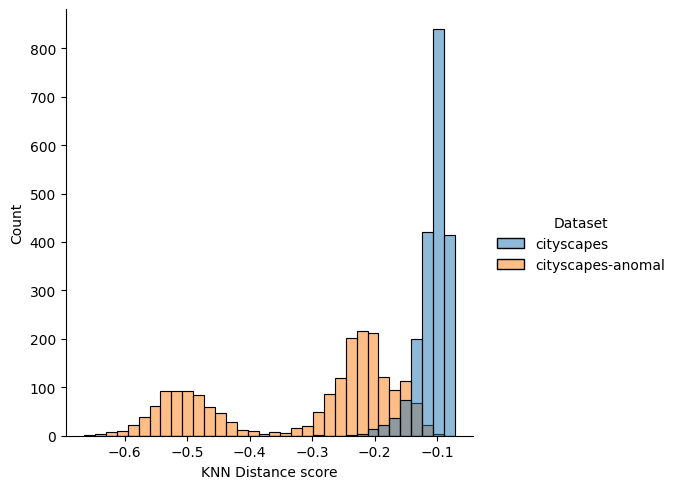

In [180]:
df_pred_kth_dist_scores = pd.concat([df_kth_dist_scores_cs,
                                     df_kth_dist_scores_cs_anomal]).reset_index(drop=True)

sns.displot(df_pred_kth_dist_scores, x="KNN Distance score", hue="Dataset", kind="hist", fill=True)
plt.show()

In [182]:
ic(ind_cs_kth_dist_score.shape);
ic(ood_cs_anomal_kth_dist_score.shape);
ic(ood_ws_kth_dist_score.shape);
ic(ood_ws_soil_kth_dist_score.shape);

ic| ind_cs_kth_dist_score.shape: (2025,)
ic| ood_cs_anomal_kth_dist_score.shape: (2025,)
ic| ood_ws_kth_dist_score.shape: (2305,)
ic| ood_ws_soil_kth_dist_score.shape: (1800

,)


### Cityscapes vs. Cityscapes-anomaly

We align with the convention where positive (in-distribution) samples have higher scores (see plots above)

In [183]:
print("Test InD shape", ind_cs_kth_dist_score.shape);
print("Test OoD shape", ood_cs_anomal_kth_dist_score.shape);

results_kth_dist_gtsrb_anomaly = get_hz_detector_results(detect_exp_name="KNN Distance score: cityscapes vs. cityscapes-anomaly",
                                                         ind_samples_scores=ind_cs_kth_dist_score,
                                                         ood_samples_scores=ood_cs_anomal_kth_dist_score)

Test InD shape (2025,)
Test OoD shape (2025,)
AUROC: 0.9868
FPR95: 0.0830
AUPR: 0.9876


### Cityscapes vs. Woodscape

We align with the convention where positive (in-distribution) samples have higher scores (see plots above)

In [184]:
print("Test InD shape", ind_cs_kth_dist_score.shape);
print("Test OoD shape", ood_ws_kth_dist_score.shape);

results_kth_dist_cifar10 = get_hz_detector_results(detect_exp_name="KNN Distance score: cityscapes vs. woodscape",
                                                 ind_samples_scores=ind_cs_kth_dist_score,
                                                 ood_samples_scores=ood_ws_kth_dist_score)

Test InD shape (2025,)
Test OoD shape (2305,)
AUROC: 0.9997
FPR95: 0.0000
AUPR: 0.9997


### Cityscapes vs. Woodscape-soiling

We align with the convention where positive (in-distribution) samples have higher scores (see plots above)

In [185]:
print("Test InD shape", ind_cs_kth_dist_score.shape);
print("Test OoD shape", ood_ws_soil_kth_dist_score.shape);

results_kth_dist_stl10 = get_hz_detector_results(detect_exp_name="KNN Distance score: cityscapes vs. woodscape-soiling",
                                                 ind_samples_scores=ind_cs_kth_dist_score,
                                                 ood_samples_scores=ood_ws_soil_kth_dist_score)

Test InD shape (2025,)
Test OoD shape (1800,)
AUROC: 1.0000
FPR95: 0.0000
AUPR: 1.0000


## KNN Distance Score penultimate layer

In [192]:
import faiss

In [193]:
class Hook:
    """
    Hook class that returns the input and output of a layer during forward/backward pass
    """
    def __init__(self, module: torch.nn.Module, backward: bool = False):
        """
        Hook Class constructor
        :param module: Layer block from Neural Network Module
        :type module: torch.nn.Module
        :param backward: backward-poss hook
        :type backward: bool
        """
        self.input = None
        self.output = None
        if not backward:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output

    def close(self):
        self.hook.remove()

In [194]:
normalizer = lambda x: x / (np.linalg.norm(x, ord=2, axis=-1, keepdims=True) + 1e-10)


In [195]:
class KNNPostprocessor:
    def __init__(self,
                 K: int = 50,
                 setup_flag: bool = False,
                 get_2d_rep_mean: bool = False):
        self.K = K
        self.activation_log = None
        self.setup_flag = setup_flag
        self.get_2d_rep_mean = get_2d_rep_mean
        self.index = None

    def setup(self,
              dnn_model: nn.Module,
              ind_dataloader,
              layer_hook):

        if not self.setup_flag:
            print('\n Get latent embeddings z from training set...')
            activation_log = []
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            dnn_model.to(device)
            
            with torch.no_grad():
                for i, (image, label) in enumerate(ind_dataloader):
                    image = image.to(device)
                    pred_logits = dnn_model(image)
                    
                    latent_rep = layer_hook.output  # latent representation sample
                    
                    if self.get_2d_rep_mean:
                        # Get image HxW mean:
                        latent_rep = torch.mean(latent_rep, dim=2, keepdim=True)
                        latent_rep = torch.mean(latent_rep, dim=3, keepdim=True)
                        # Remove useless dimensions:
                        latent_rep = torch.squeeze(latent_rep, dim=2)
                        latent_rep = torch.squeeze(latent_rep, dim=2)
                    
                    # latent_rep = torch.flatten(layer_hook.output, 1)  # latent representation sample
                    # ic(layer_hook.output)
                    activation_log.append(
                        normalizer(latent_rep.data.cpu().numpy()))

            self.activation_log = np.concatenate(activation_log, axis=0)
            self.index = faiss.IndexFlatL2(latent_rep.shape[1])
            self.index.add(self.activation_log)
            self.setup_flag = True
        else:
            pass

    @torch.no_grad()
    def postprocess(self,
                    dnn_model: nn.Module,
                    dataloader: DataLoader,
                    layer_hook):
        
        all_preds = []
        all_kth_dist_score = []
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        dnn_model.to(device)
        
        for i, (image, label) in enumerate(dataloader):
            image = image.to(device)
            pred_logits = dnn_model(image)
            # ic(layer_hook.output)
            # latent_rep = torch.flatten(layer_hook.output, 1)  # latent representation sample
            latent_rep = layer_hook.output  # latent representation sample
            
            if self.get_2d_rep_mean:
                # Get image HxW mean:
                latent_rep = torch.mean(latent_rep, dim=2, keepdim=True)
                latent_rep = torch.mean(latent_rep, dim=3, keepdim=True)
                # Remove useless dimensions:
                latent_rep = torch.squeeze(latent_rep, dim=2)
                latent_rep = torch.squeeze(latent_rep, dim=2)
            
            pred = torch.max(torch.softmax(pred_logits, dim=1), dim=1)
            latent_rep_normed = normalizer(latent_rep.data.cpu().numpy())
            
            D, _ = self.index.search(
                latent_rep_normed,
                self.K)
            kth_dist = -D[:, -1]
            
            all_preds.append(pred[0])
            all_kth_dist_score.append(kth_dist)
            
        all_preds_t = torch.cat(all_preds)
        # all_kth_dist_score_t = torch.cat(all_kth_dist_score)
        all_kth_dist_score_np = np.concatenate(all_kth_dist_score, axis=0)
        
        return all_preds_t, all_kth_dist_score_np

    def set_K_hyperparam(self, hyperparam: int = 50):
        self.K = hyperparam

    def get_K_hyperparam(self):
        return self.K

In [196]:
ic(len(cs_dlv3p_train_loader));
ic(len(cs_dlv3p_valid_loader));
ic(len(cs_dlv3p_test_loader));
ic("========================================");
ic(len(cs_dlv3p_anomaly_valid_loader));
ic(len(cs_dlv3p_anomaly_test_loader));
ic("========================================");
ic(len(ws_256512_dlv3p_valid_loader));
ic(len(ws_256512_dlv3p_test_loader));
ic("========================================");
ic(len(ws_soiling_256512_valid_loader));
ic(len(ws_soiling_256512_test_loader));

ic| len(cs_dlv3p_train_loader): 2975
ic| len(cs_dlv3p_valid_loader): 500
ic| len(cs_dlv3p_test_loader): 1525


ic| '========================================'
ic| len(cs_dlv3p_anomaly_valid_loader): 500
ic| len(cs_dlv3p_anomaly_test_loader): 1525
ic| '========================================'
ic| len(ws_256512_dlv3p_valid_loader): 1482
ic| len(ws_256512_dlv3p_test_loader): 823
ic| '========================================'
ic| len(ws_soiling_256512_valid_loader): 800
ic| len(ws_soiling_256512_test_loader): 1000


### Add Model Hook

In [197]:
cs_dlv3p_hook_penultimate_layer = Hook(cs_dlv3p_model.deeplab_v3plus_model.classifier.classifier[2])
cs_dlv3p_hook_penultimate_layer

### KNN Dist Setup

In [198]:
knn_dist_cs_dlv3p = KNNPostprocessor(K=50, setup_flag=False, get_2d_rep_mean=True)

In [199]:
knn_dist_cs_dlv3p.setup(cs_dlv3p_model.deeplab_v3plus_model,
                        cs_dlv3p_train_loader,
                        layer_hook=cs_dlv3p_hook_penultimate_layer)


 Get latent embeddings z from training set...


### KNN Kth-Dist Scores

In [200]:
_, ind_cs_valid_kth_dist_score = knn_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                               cs_dlv3p_valid_loader,
                                                               cs_dlv3p_hook_penultimate_layer)


_, ind_cs_test_kth_dist_score = knn_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                              cs_dlv3p_test_loader,
                                                              cs_dlv3p_hook_penultimate_layer)


_, ood_cs_anomal_valid_kth_dist_score = knn_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                                      cs_dlv3p_anomaly_valid_loader,
                                                                      cs_dlv3p_hook_penultimate_layer)

_, ood_cs_anomal_test_kth_dist_score = knn_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                                     cs_dlv3p_anomaly_test_loader,
                                                                     cs_dlv3p_hook_penultimate_layer)


_, ood_ws_valid_kth_dist_score = knn_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                               ws_256512_dlv3p_valid_loader,
                                                               cs_dlv3p_hook_penultimate_layer)

_, ood_ws_test_kth_dist_score = knn_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                              ws_256512_dlv3p_test_loader,
                                                              cs_dlv3p_hook_penultimate_layer)


_, ood_ws_soil_valid_kth_dist_score = knn_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                                    ws_soiling_256512_valid_loader,
                                                                    cs_dlv3p_hook_penultimate_layer)

_, ood_ws_soil_test_kth_dist_score = knn_dist_cs_dlv3p.postprocess(cs_dlv3p_model.deeplab_v3plus_model,
                                                                   ws_soiling_256512_test_loader,
                                                                   cs_dlv3p_hook_penultimate_layer)

In [201]:
ind_cs_kth_dist_score = np.concatenate((ind_cs_valid_kth_dist_score, ind_cs_test_kth_dist_score))
ood_cs_anomal_kth_dist_score = np.concatenate((ood_cs_anomal_valid_kth_dist_score, ood_cs_anomal_test_kth_dist_score))
ood_ws_kth_dist_score = np.concatenate((ood_ws_valid_kth_dist_score, ood_ws_test_kth_dist_score))
ood_ws_soil_kth_dist_score = np.concatenate((ood_ws_soil_valid_kth_dist_score, ood_ws_soil_test_kth_dist_score))

In [ ]:
knn_dist_penultimate_layer_score_path

In [152]:
np.save(knn_dist_penultimate_layer_score_path + 'ind_cs_kth_dist_score',
        ind_cs_kth_dist_score)

np.save(knn_dist_penultimate_layer_score_path + 'ood_cs_anomal_kth_dist_score',
        ood_cs_anomal_kth_dist_score)

np.save(knn_dist_penultimate_layer_score_path + 'ood_ws_kth_dist_score',
        ood_ws_kth_dist_score)

np.save(knn_dist_penultimate_layer_score_path + 'ood_ws_soil_kth_dist_score',
        ood_ws_soil_kth_dist_score)

In [203]:
ic(ind_cs_kth_dist_score.shape);
ic(ood_cs_anomal_kth_dist_score.shape);
ic(ood_ws_kth_dist_score.shape);
ic(ood_ws_soil_kth_dist_score.shape);

ic| ind_cs_kth_dist_score.shape: (2025,)
ic| ood_cs_anomal_kth_dist_score.shape: (2025,)
ic| ood_ws_kth_dist_score.shape: (2305,)
ic| ood_ws_soil_kth_dist_score.shape: (1800,)


In [204]:
df_kth_dist_scores_cs = pd.DataFrame(ind_cs_kth_dist_score, columns=["KNN Distance score"])
df_kth_dist_scores_cs_anomal = pd.DataFrame(ood_cs_anomal_kth_dist_score, columns=["KNN Distance score"])
df_kth_dist_scores_ws = pd.DataFrame(ood_ws_kth_dist_score, columns=["KNN Distance score"])
df_kth_dist_scores_ws_soil = pd.DataFrame(ood_ws_soil_kth_dist_score, columns=["KNN Distance score"])

df_kth_dist_scores_cs.insert(0, "Dataset", "")
df_kth_dist_scores_cs.loc[:, "Dataset"] = "cityscapes"

df_kth_dist_scores_cs_anomal.insert(0, "Dataset", "")
df_kth_dist_scores_cs_anomal.loc[:, "Dataset"] = "cityscapes-anomal"

df_kth_dist_scores_ws.insert(0, "Dataset", "")
df_kth_dist_scores_ws.loc[:, "Dataset"] = "woodscape"

df_kth_dist_scores_ws_soil.insert(0, "Dataset", "")
df_kth_dist_scores_ws_soil.loc[:, "Dataset"] = "woodscape-soiling"

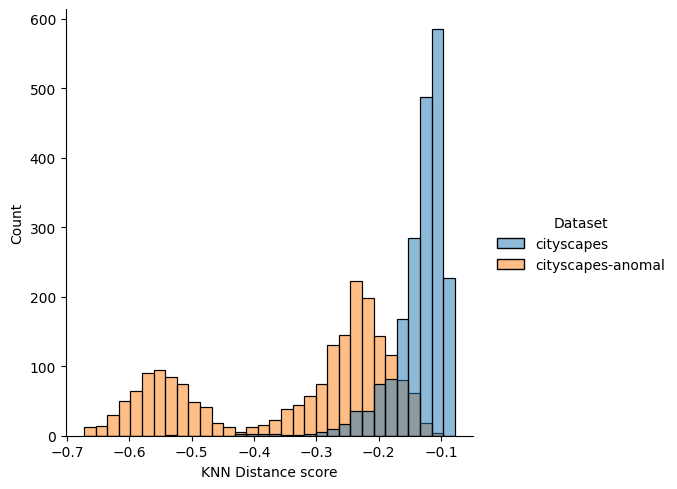

In [206]:
df_pred_kth_dist_scores = pd.concat([df_kth_dist_scores_cs,
                                     df_kth_dist_scores_cs_anomal]).reset_index(drop=True)

sns.displot(df_pred_kth_dist_scores, x="KNN Distance score", hue="Dataset", kind="hist", fill=True)
plt.show()

In [207]:
ic(ind_cs_kth_dist_score.shape);
ic(ood_cs_anomal_kth_dist_score.shape);
ic(ood_ws_kth_dist_score.shape);
ic(ood_ws_soil_kth_dist_score.shape);

ic| ind_cs_kth_dist_score.shape: (2025,)
ic| ood_cs_anomal_kth_dist_score.shape: (2025,)
ic| ood_ws_kth_dist_score.shape: (2305,)
ic| ood_ws_soil_kth_dist_score.shape: (1800,)


### Cityscapes vs. Cityscapes-anomaly

We align with the convention where positive (in-distribution) samples have higher scores (see plots above)

In [208]:
print("Test InD shape", ind_cs_kth_dist_score.shape);
print("Test OoD shape", ood_cs_anomal_kth_dist_score.shape);

results_kth_dist_gtsrb_anomaly = get_hz_detector_results(detect_exp_name="KNN Distance score: cityscapes vs. cityscapes-anomaly",
                                                         ind_samples_scores=ind_cs_kth_dist_score,
                                                         ood_samples_scores=ood_cs_anomal_kth_dist_score)

Test InD shape (2025,)
Test OoD shape (2025,)
AUROC: 0.9562
FPR95: 0.2435
AUPR: 0.9600


### Cityscapes vs. Woodscape

We align with the convention where positive (in-distribution) samples have higher scores (see plots above)

In [209]:
print("Test InD shape", ind_cs_kth_dist_score.shape);
print("Test OoD shape", ood_ws_kth_dist_score.shape);

results_kth_dist_cifar10 = get_hz_detector_results(detect_exp_name="KNN Distance score: cityscapes vs. woodscape",
                                                 ind_samples_scores=ind_cs_kth_dist_score,
                                                 ood_samples_scores=ood_ws_kth_dist_score)

Test InD shape (2025,)
Test OoD shape (2305,)
AUROC: 0.9962
FPR95: 0.0048
AUPR: 0.9967


### Cityscapes vs. Woodscape-soiling

We align with the convention where positive (in-distribution) samples have higher scores (see plots above)

In [210]:
print("Test InD shape", ind_cs_kth_dist_score.shape);
print("Test OoD shape", ood_ws_soil_kth_dist_score.shape);

results_kth_dist_stl10 = get_hz_detector_results(detect_exp_name="KNN Distance score: cityscapes vs. woodscape-soiling",
                                                 ind_samples_scores=ind_cs_kth_dist_score,
                                                 ood_samples_scores=ood_ws_soil_kth_dist_score)

Test InD shape (2025,)
Test OoD shape (1800,)
AUROC: 0.9987
FPR95: 0.0000
AUPR: 0.9992
